# <font color=green>GuruStock - A Comparative Study of Stock Price Prediction using Sentiment Analysis</font>

## **<font color=red>Sentiment Analysis of the Stocks</font>**

### Libraries and Modules

In [1]:
from textblob import TextBlob
import tweepy 
from tweepy import OAuthHandler
import os
import sys
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt

### Keys and Tokens for Twitter API

In [2]:
consumer_key = "vYnC9KnfWBn8glDIkLh0wu2Ew"
consumer_secret = "iUQHBV0GYS69Xoopz8LV6EGlEteTpTeTtw734S4HILMYS7EAWM"
access_token = "1084360003132125186-IisxCooPrfinEgPhlChrFuCSJDGUlF"
bearer_token = "AAAAAAAAAAAAAAAAAAAAANF4bQEAAAAAodBJIvocEsuKvR55%2FedDUkghF0U%3DOlEdqAculLBurvJI7A5zUeSMdzkfOgzMBqqUha4Bh45oEDPyyq"
access_token_secret = "DsxIfsPzqeZCl0oA51VZn5mNVPPDmpLC1lb5YcAJmgnA3"

### Authentication

In [3]:
try: 
    # create OAuthHandler object 
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
    # set access token and secret 
    auth.set_access_token(access_token, access_token_secret)
    # create tweepy API object to fetch tweets 
    api = tweepy.API(auth)
except: 
    print("Error: Authentication Failed")

### Fetching

In [4]:
query = input("Please enter a stock quote from the CSV to perform the search: ").upper()

# Checks if the sentiment for our quote is positive or negative
list_of_tweets = api.search_30_day(label = "Development", query = query, maxResults= 100)
num_tweets = 100

Please enter a stock quote from the CSV to perform the search: INTC


### Subjective Analysis

In [5]:
polarity = 0
positive = 0
negative = 0
neutral = 0
null = 0

flag = False

for tweet in list_of_tweets:
    analysis = TextBlob(tweet.text)
   #print(analysis)
    polarity = analysis.sentiment.polarity
   #print(polarity)
    if analysis.subjectivity == 0:  
        null += 1
        next
    if polarity < 0:
        negative += 1
    elif polarity == 0:
        neutral += 1
    else:
        positive += 1
        
if positive > ((num_tweets - null)/2):
    flag = True
    
if not flag:
    print('This stock has bad sentiment, please re-run the script')
    sys.exit()
else:
    print('This stock has good sentiment')

This stock has good sentiment


###  Visualization

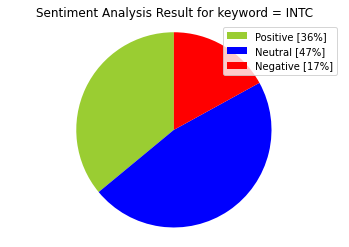

In [6]:
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword = "+query)
plt.axis('equal')
plt.show()

## <font color=red>**Fetching previous data using Yfinance**</font>

### Modules and Libraries

In [7]:
import yfinance as yf

### Fetching the Dataset 

In [8]:
if yf.Ticker(query) != 400:
    value = yf.Ticker(query)
    hist = value.history(period="5y")
    hist.to_csv('hist.csv')
else:
    raise RuntimeError('Connection Failed')
    
df = pd.read_csv('hist.csv')

## <font color = red>**The Linear Regression Model**</font> 

### Modules and Libraries

In [9]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

### Preprocessing the Dataset

In [10]:
df3 = df.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0,1))
df3 = scaler.fit_transform(np.array(df3).reshape(-1,1))

def create_dataset(dataset, time_step=1):
    val = (len(dataset)-time_step-1)
    dataX, dataY = [], []
    for i in range(val):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

### Train-Test Split

In [11]:
training_size=int(len(df3)*0.65)
test_size=len(df3)-training_size

train_data,test_data=df3[0:training_size,:],df3[training_size:len(df3),:1]

time_step = 100
X_train1, y_train1 = create_dataset(train_data, time_step)
X_test1, y_test1 = create_dataset(test_data, time_step)

### Fitting the model

In [12]:
model3 = LinearRegression()
model3.fit(X_train1,y_train1)

LinearRegression()

### Predicting and Reverse transforming

In [13]:
y_pred = model3.predict(X_test1)
y_pred = y_pred.reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)

train_predict = model3.predict(X_train1)
train_predict = train_predict.reshape(-1,1)
train_predict=scaler.inverse_transform(train_predict)

### Performance Analysis

In [14]:
print("RMS error when using Linear Regression on training data: ",math.sqrt(mean_squared_error(y_train1, train_predict)))
print("RMS error when using Linear Regression on testing data: ",math.sqrt(mean_squared_error(y_test1, y_pred)))

RMS error when using Linear Regression on training data:  47.63248786475377
RMS error when using Linear Regression on testing data:  50.82081062824633


### Visualization

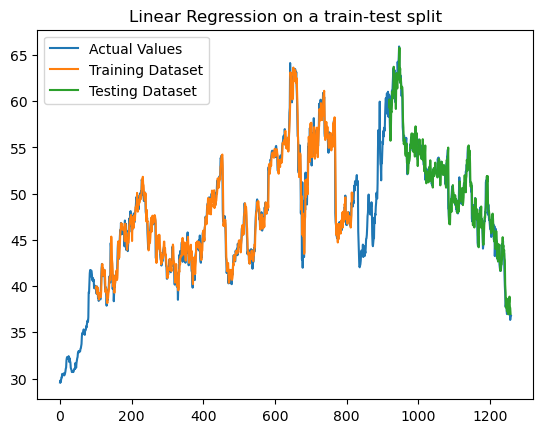

In [15]:
look_back=100
trainPredictPlot = np.empty_like(df3)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

test_predict = y_pred
testPredictPlot = np.empty_like(df3)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df3)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df3))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

labels = ['Actual Values' , 'Training Dataset', 'Testing Dataset']
plt.title("Linear Regression on a train-test split")
plt.legend(labels)
plt.show()

## <font color=red>**The Random Forest Regressor Model**</font>

### Modules and Libraries

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Preprocessing the Dataset

In [17]:
df2 = df.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))

def create_dataset(dataset, time_step=1):
    val = (len(dataset)-time_step-1)
    dataX, dataY = [], []
    for i in range(val):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

### Train-Test Split

In [18]:
training_size=int(len(df2)*0.65)
test_size=len(df2)-training_size

train_data,test_data=df2[0:training_size,:],df2[training_size:len(df2),:1]
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])

### Hyperparameter Tuning

In [19]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 5500, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8, 16]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Randomized K-fold Fitting

In [20]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 19, 28, 37, 46, 55,
                                                      64, 73, 82, 91, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 8, 16],
                                        'min_samples_split': [2, 4, 5, 10, 20],
                                        'n_estimators': [500, 550, 601, 651,
                                                         702, 752, 803, 853,
                                                         904, 954, 1005, 1055,
                                                         1106, 1156, 1207, 1257,
                                                         1308, 1358, 1409,

### Best Parameters and Performance Evaluation

In [21]:
best_parameters = rf_random.best_params_
print(best_parameters)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))   
    return accuracy

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

{'n_estimators': 5045, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
Model Performance
Average Error: 0.0259 degrees.
Accuracy = 94.41%.


<font color=blue>{'n_estimators': 3530, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}</font>

### Predicting and Reverse transforming

In [22]:
train_predict=best_random.predict(X_train)
train_predict=train_predict.reshape(-1, 1)
train_predict = scaler.inverse_transform(train_predict)
array_length = len(train_predict)
val = train_predict[array_length - 1]

test_predict=best_random.predict(X_test)
test_predict=test_predict.reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict)
array_length = len(test_predict)
val_test = test_predict[array_length - 1]

print("RMS error when using Random Forest Regression on training data: ",math.sqrt(mean_squared_error(y_train, train_predict)))
print("RMS error when using Random Forest Regression on testing data: ",math.sqrt(mean_squared_error(y_test, test_predict)))

RMS error when using Random Forest Regression on training data:  47.63071380470057
RMS error when using Random Forest Regression on testing data:  51.03450982905625


### Visualization

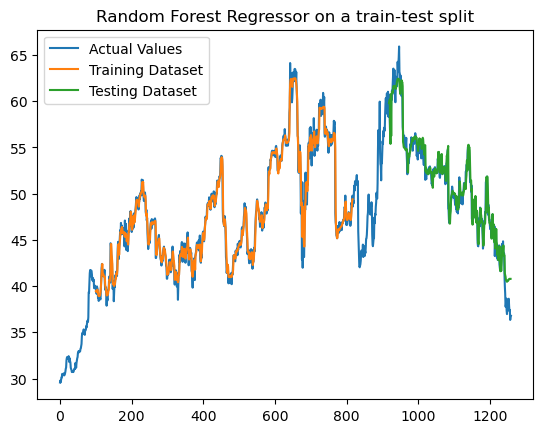

In [23]:
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

labels = ['Actual Values' , 'Training Dataset', 'Testing Dataset']
plt.title("Random Forest Regressor on a train-test split")
plt.legend(labels)
plt.show()

## <font color=red>**The LSTM-TLBO model**</font>

### Modules and Libraries - LSTM

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow import keras

### Preprocessing the Dataset

In [25]:
df1 = df.reset_index()['Close']
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))  

def create_dataset(dataset, time_step=1):
    val = (len(dataset)-time_step-1)
    dataX, dataY = [], []
    for i in range(val):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
X, Y = create_dataset(df1, time_step)

# reshape input to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0],X.shape[1] , 1)   

### Layers in the LSTM Model

In [26]:
# Creating a Multilinear Perceptron model
model = Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))  

model.add(Dense(units=1))   

### Train-Test Split

In [27]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size

train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Compiling, Fitting and Saving

In [28]:
optimizer = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2, validation_data=(X_test, y_test))

model.save('Final_model.h5')

Epoch 1/100
72/72 - 11s - loss: 0.0276 - val_loss: 0.0047 - 11s/epoch - 154ms/step
Epoch 2/100
72/72 - 5s - loss: 0.0093 - val_loss: 0.0042 - 5s/epoch - 76ms/step
Epoch 3/100
72/72 - 5s - loss: 0.0093 - val_loss: 0.0052 - 5s/epoch - 72ms/step
Epoch 4/100
72/72 - 5s - loss: 0.0075 - val_loss: 0.0033 - 5s/epoch - 75ms/step
Epoch 5/100
72/72 - 6s - loss: 0.0061 - val_loss: 0.0071 - 6s/epoch - 80ms/step
Epoch 6/100
72/72 - 5s - loss: 0.0057 - val_loss: 0.0033 - 5s/epoch - 72ms/step
Epoch 7/100
72/72 - 6s - loss: 0.0063 - val_loss: 0.0029 - 6s/epoch - 87ms/step
Epoch 8/100
72/72 - 6s - loss: 0.0059 - val_loss: 0.0031 - 6s/epoch - 77ms/step
Epoch 9/100
72/72 - 6s - loss: 0.0058 - val_loss: 0.0033 - 6s/epoch - 80ms/step
Epoch 10/100
72/72 - 5s - loss: 0.0053 - val_loss: 0.0035 - 5s/epoch - 71ms/step
Epoch 11/100
72/72 - 7s - loss: 0.0043 - val_loss: 0.0044 - 7s/epoch - 94ms/step
Epoch 12/100
72/72 - 6s - loss: 0.0050 - val_loss: 0.0026 - 6s/epoch - 80ms/step
Epoch 13/100
72/72 - 5s - loss: 0.

### Modules and Libraries - TLBO

In [29]:
from mealpy.human_based.TLO import BaseTLO

### The TLBO Model

In [30]:
def TLBO(wts):
    def fitness_rastrigin(position):
        fitness_value = 0.0
        for i in range(len(position)):
            xi = position[i]
            fitness_value += (xi * xi) - (10 * math.cos(2 * math.pi * xi)) + 10
        return fitness_value
     
    def fitness_sphere(position):
        fitness_value = 0.0
        for i in range(len(position)):
            xi = position[i]
            fitness_value += (xi*xi);
        return fitness_value
    
    def fitness_function(position):
        return np.sum(position**2)
    
    problem_dict = {
        "fit_func": fitness_rastrigin,
        "lb": [np.min(wts),-10,0,10],
        "ub": [np.max(wts),10,0,-10],
        "minmax": "min",
    }
    epoch = 100
    pop_size = 50
    model_optim = BaseTLO(problem_dict, epoch, pop_size)
    best_position, best_fitness = model_optim.solve()
    print(f"Solution: {best_position}, Fitness: {best_fitness}")
    return best_position

### Optimizing the LSTM Model with TLBO

In [31]:
wts_mat = []
for i in range(0,7,2):
    wts_mat.append(TLBO(model.weights[i]))
wts_mat = np.array(wts_mat)
print(wts_mat.shape)

2022/07/06 10:39:57 PM, INFO, mealpy.human_based.TLO.BaseTLO: Solving single objective optimization problem.
2022/07/06 10:39:57 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 1, Current best: 102.43482467475233, Global best: 102.43482467475233, Runtime: 0.01279 seconds
2022/07/06 10:39:57 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 2, Current best: 101.80450356300541, Global best: 101.80450356300541, Runtime: 0.01681 seconds
2022/07/06 10:39:57 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 3, Current best: 101.80450356300541, Global best: 101.80450356300541, Runtime: 0.02535 seconds
2022/07/06 10:39:57 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 4, Current best: 100.41818481682745, Global best: 100.41818481682745, Runtime: 0.02155 seconds
2022/07/06 10:39:57 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 5, Current best: 100.23759598357597, Global best: 100.23759598357597, Runtime: 0.01964 seconds
2022/07/06 10:39:57 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epo

2022/07/06 10:39:58 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 50, Current best: 100.00000000000998, Global best: 100.00000000000998, Runtime: 0.02239 seconds
2022/07/06 10:39:58 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 51, Current best: 100.00000000000998, Global best: 100.00000000000998, Runtime: 0.02045 seconds
2022/07/06 10:39:58 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 52, Current best: 100.0000000000018, Global best: 100.0000000000018, Runtime: 0.01690 seconds
2022/07/06 10:39:58 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 53, Current best: 100.0000000000018, Global best: 100.0000000000018, Runtime: 0.02689 seconds
2022/07/06 10:39:58 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 54, Current best: 100.0000000000018, Global best: 100.0000000000018, Runtime: 0.01827 seconds
2022/07/06 10:39:58 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 55, Current best: 100.00000000000028, Global best: 100.00000000000028, Runtime: 0.03216 seconds
2022/07/06

2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 3, Current best: 101.9942644676985, Global best: 101.9942644676985, Runtime: 0.01035 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 3, Current best: 101.9942644676985, Global best: 101.9942644676985, Runtime: 0.01035 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 4, Current best: 101.8934429545865, Global best: 101.8934429545865, Runtime: 0.01181 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 4, Current best: 101.8934429545865, Global best: 101.8934429545865, Runtime: 0.01181 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 5, Current best: 101.8934429545865, Global best: 101.8934429545865, Runtime: 0.01359 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 5, Current best: 101.8934429545865, Global best: 101.8934429545865, Runtime: 0.01359 seconds
2022/07/06 10:39:59 PM

Solution: [ 2.32450305e-09  1.11580884e-10  0.00000000e+00 -1.00000000e+01], Fitness: 100.0


2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 13, Current best: 101.04830092977468, Global best: 101.04830092977468, Runtime: 0.01168 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 13, Current best: 101.04830092977468, Global best: 101.04830092977468, Runtime: 0.01168 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 14, Current best: 101.03275320311621, Global best: 101.03275320311621, Runtime: 0.01196 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 14, Current best: 101.03275320311621, Global best: 101.03275320311621, Runtime: 0.01196 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 15, Current best: 100.18755628224943, Global best: 100.18755628224943, Runtime: 0.01184 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 15, Current best: 100.18755628224943, Global best: 100.18755628224943, Runtime: 0.01184 seconds
2022

2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 38, Current best: 100.0004293127088, Global best: 100.0004293127088, Runtime: 0.01222 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 38, Current best: 100.0004293127088, Global best: 100.0004293127088, Runtime: 0.01222 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 39, Current best: 100.0004293127088, Global best: 100.0004293127088, Runtime: 0.01285 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 39, Current best: 100.0004293127088, Global best: 100.0004293127088, Runtime: 0.01285 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 40, Current best: 100.0001969166308, Global best: 100.0001969166308, Runtime: 0.01007 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 40, Current best: 100.0001969166308, Global best: 100.0001969166308, Runtime: 0.01007 seconds
2022/07/06 10:39

2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 63, Current best: 100.00000014010182, Global best: 100.00000014010182, Runtime: 0.01064 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 63, Current best: 100.00000014010182, Global best: 100.00000014010182, Runtime: 0.01064 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 64, Current best: 100.00000000015174, Global best: 100.00000000015174, Runtime: 0.01188 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 64, Current best: 100.00000000015174, Global best: 100.00000000015174, Runtime: 0.01188 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 65, Current best: 100.00000000015174, Global best: 100.00000000015174, Runtime: 0.01245 seconds
2022/07/06 10:39:59 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 65, Current best: 100.00000000015174, Global best: 100.00000000015174, Runtime: 0.01245 seconds
2022

2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 88, Current best: 100.00000000000014, Global best: 100.00000000000014, Runtime: 0.01210 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 88, Current best: 100.00000000000014, Global best: 100.00000000000014, Runtime: 0.01210 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 89, Current best: 100.00000000000014, Global best: 100.00000000000014, Runtime: 0.01171 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 89, Current best: 100.00000000000014, Global best: 100.00000000000014, Runtime: 0.01171 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 90, Current best: 100.00000000000014, Global best: 100.00000000000014, Runtime: 0.00951 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 90, Current best: 100.00000000000014, Global best: 100.00000000000014, Runtime: 0.00951 seconds
2022

2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 9, Current best: 100.02368527977764, Global best: 100.02368527977764, Runtime: 0.01150 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 9, Current best: 100.02368527977764, Global best: 100.02368527977764, Runtime: 0.01150 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 9, Current best: 100.02368527977764, Global best: 100.02368527977764, Runtime: 0.01150 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 10, Current best: 100.02368527977764, Global best: 100.02368527977764, Runtime: 0.01347 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 10, Current best: 100.02368527977764, Global best: 100.02368527977764, Runtime: 0.01347 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 10, Current best: 100.02368527977764, Global best: 100.02368527977764, Runtime: 0.01347 seconds
2022/07

Solution: [-1.34715899e-09  2.61713767e-09  0.00000000e+00 -1.00000000e+01], Fitness: 100.0


2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 12, Current best: 100.01658660064359, Global best: 100.01658660064359, Runtime: 0.01204 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 12, Current best: 100.01658660064359, Global best: 100.01658660064359, Runtime: 0.01204 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 13, Current best: 100.01658660064359, Global best: 100.01658660064359, Runtime: 0.01311 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 13, Current best: 100.01658660064359, Global best: 100.01658660064359, Runtime: 0.01311 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 13, Current best: 100.01658660064359, Global best: 100.01658660064359, Runtime: 0.01311 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 14, Current best: 100.01658660064359, Global best: 100.01658660064359, Runtime: 0.01261 seconds
2022

2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 29, Current best: 100.00006319699096, Global best: 100.00006319699096, Runtime: 0.01136 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 29, Current best: 100.00006319699096, Global best: 100.00006319699096, Runtime: 0.01136 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 29, Current best: 100.00006319699096, Global best: 100.00006319699096, Runtime: 0.01136 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 30, Current best: 100.00006319699096, Global best: 100.00006319699096, Runtime: 0.01126 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 30, Current best: 100.00006319699096, Global best: 100.00006319699096, Runtime: 0.01126 seconds
2022/07/06 10:40:00 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 30, Current best: 100.00006319699096, Global best: 100.00006319699096, Runtime: 0.01126 seconds
2022

2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 45, Current best: 100.00000001807742, Global best: 100.00000001807742, Runtime: 0.01281 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 46, Current best: 100.00000000974538, Global best: 100.00000000974538, Runtime: 0.01309 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 46, Current best: 100.00000000974538, Global best: 100.00000000974538, Runtime: 0.01309 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 46, Current best: 100.00000000974538, Global best: 100.00000000974538, Runtime: 0.01309 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 47, Current best: 100.00000000974538, Global best: 100.00000000974538, Runtime: 0.01125 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 47, Current best: 100.00000000974538, Global best: 100.00000000974538, Runtime: 0.01125 seconds
2022

2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 62, Current best: 100.00000000000121, Global best: 100.00000000000121, Runtime: 0.01125 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 62, Current best: 100.00000000000121, Global best: 100.00000000000121, Runtime: 0.01125 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 63, Current best: 100.0000000000001, Global best: 100.0000000000001, Runtime: 0.01081 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 63, Current best: 100.0000000000001, Global best: 100.0000000000001, Runtime: 0.01081 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 63, Current best: 100.0000000000001, Global best: 100.0000000000001, Runtime: 0.01081 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 64, Current best: 100.0000000000001, Global best: 100.0000000000001, Runtime: 0.01152 seconds
2022/07/06 1

2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 81, Current best: 100.0, Global best: 100.0, Runtime: 0.01069 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 81, Current best: 100.0, Global best: 100.0, Runtime: 0.01069 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 81, Current best: 100.0, Global best: 100.0, Runtime: 0.01069 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 82, Current best: 100.0, Global best: 100.0, Runtime: 0.01163 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 82, Current best: 100.0, Global best: 100.0, Runtime: 0.01163 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 82, Current best: 100.0, Global best: 100.0, Runtime: 0.01163 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 83, Current best: 100.0, Global best: 100.0, Runtime: 0.01042 seconds
2022/07/06 10:40:01 

2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 100, Current best: 100.0, Global best: 100.0, Runtime: 0.01214 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: Solving single objective optimization problem.
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: Solving single objective optimization problem.
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: Solving single objective optimization problem.
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: Solving single objective optimization problem.
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 1, Current best: 103.95702328818118, Global best: 103.95702328818118, Runtime: 0.01215 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 1, Current best: 103.95702328818118, Global best: 103.95702328818118, Runtime: 0.01215 seconds
2022/07/06 10:40:01 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 1, Current best: 103.95

2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 12, Current best: 100.00602825169608, Global best: 100.00602825169608, Runtime: 0.01041 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 13, Current best: 100.00602825169608, Global best: 100.00602825169608, Runtime: 0.01097 seconds


Solution: [-1.65271784e-09  3.34438396e-09  0.00000000e+00 -1.00000000e+01], Fitness: 100.0


2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 13, Current best: 100.00602825169608, Global best: 100.00602825169608, Runtime: 0.01097 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 13, Current best: 100.00602825169608, Global best: 100.00602825169608, Runtime: 0.01097 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 13, Current best: 100.00602825169608, Global best: 100.00602825169608, Runtime: 0.01097 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 14, Current best: 100.00602825169608, Global best: 100.00602825169608, Runtime: 0.01151 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 14, Current best: 100.00602825169608, Global best: 100.00602825169608, Runtime: 0.01151 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 14, Current best: 100.00602825169608, Global best: 100.00602825169608, Runtime: 0.01151 seconds
2022

2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 25, Current best: 100.00038756090612, Global best: 100.00038756090612, Runtime: 0.01018 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 26, Current best: 100.0001656633394, Global best: 100.0001656633394, Runtime: 0.01221 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 26, Current best: 100.0001656633394, Global best: 100.0001656633394, Runtime: 0.01221 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 26, Current best: 100.0001656633394, Global best: 100.0001656633394, Runtime: 0.01221 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 26, Current best: 100.0001656633394, Global best: 100.0001656633394, Runtime: 0.01221 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 27, Current best: 100.00010964950101, Global best: 100.00010964950101, Runtime: 0.01104 seconds
2022/07/06 1

2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 38, Current best: 100.00000075854193, Global best: 100.00000075854193, Runtime: 0.01023 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 38, Current best: 100.00000075854193, Global best: 100.00000075854193, Runtime: 0.01023 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 38, Current best: 100.00000075854193, Global best: 100.00000075854193, Runtime: 0.01023 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 39, Current best: 100.00000075854193, Global best: 100.00000075854193, Runtime: 0.01101 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 39, Current best: 100.00000075854193, Global best: 100.00000075854193, Runtime: 0.01101 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 39, Current best: 100.00000075854193, Global best: 100.00000075854193, Runtime: 0.01101 seconds
2022

2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 50, Current best: 100.00000000007144, Global best: 100.00000000007144, Runtime: 0.01078 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 51, Current best: 100.00000000007144, Global best: 100.00000000007144, Runtime: 0.01074 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 51, Current best: 100.00000000007144, Global best: 100.00000000007144, Runtime: 0.01074 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 51, Current best: 100.00000000007144, Global best: 100.00000000007144, Runtime: 0.01074 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 51, Current best: 100.00000000007144, Global best: 100.00000000007144, Runtime: 0.01074 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 52, Current best: 100.00000000007144, Global best: 100.00000000007144, Runtime: 0.01060 seconds
2022

2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 63, Current best: 100.0000000000006, Global best: 100.0000000000006, Runtime: 0.01116 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 63, Current best: 100.0000000000006, Global best: 100.0000000000006, Runtime: 0.01116 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 63, Current best: 100.0000000000006, Global best: 100.0000000000006, Runtime: 0.01116 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 64, Current best: 100.00000000000045, Global best: 100.00000000000045, Runtime: 0.00996 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 64, Current best: 100.00000000000045, Global best: 100.00000000000045, Runtime: 0.00996 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 64, Current best: 100.00000000000045, Global best: 100.00000000000045, Runtime: 0.00996 seconds
2022/07/06

2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 76, Current best: 100.0, Global best: 100.0, Runtime: 0.01052 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 77, Current best: 100.0, Global best: 100.0, Runtime: 0.01193 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 77, Current best: 100.0, Global best: 100.0, Runtime: 0.01193 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 77, Current best: 100.0, Global best: 100.0, Runtime: 0.01193 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 77, Current best: 100.0, Global best: 100.0, Runtime: 0.01193 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 78, Current best: 100.0, Global best: 100.0, Runtime: 0.01026 seconds
2022/07/06 10:40:02 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 78, Current best: 100.0, Global best: 100.0, Runtime: 0.01026 seconds
2022/07/06 10:40:02 

2022/07/06 10:40:03 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 91, Current best: 100.0, Global best: 100.0, Runtime: 0.01058 seconds
2022/07/06 10:40:03 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 91, Current best: 100.0, Global best: 100.0, Runtime: 0.01058 seconds
2022/07/06 10:40:03 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 92, Current best: 100.0, Global best: 100.0, Runtime: 0.01043 seconds
2022/07/06 10:40:03 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 92, Current best: 100.0, Global best: 100.0, Runtime: 0.01043 seconds
2022/07/06 10:40:03 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 92, Current best: 100.0, Global best: 100.0, Runtime: 0.01043 seconds
2022/07/06 10:40:03 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 92, Current best: 100.0, Global best: 100.0, Runtime: 0.01043 seconds
2022/07/06 10:40:03 PM, INFO, mealpy.human_based.TLO.BaseTLO: >Epoch: 93, Current best: 100.0, Global best: 100.0, Runtime: 0.01099 seconds
2022/07/06 10:40:03 

Solution: [-3.72550875e-09 -5.09143072e-10  0.00000000e+00 -1.00000000e+01], Fitness: 100.0
(4, 4)


### Predicting and reverse transforming

In [32]:
train_predict=model.predict(X_train)

train_predict = scaler.inverse_transform(train_predict)
array_length = len(train_predict)
val = train_predict[array_length - 1]

test_predict=model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
array_length = len(test_predict)
val_test = test_predict[array_length - 1]

### Performance Analysis

In [33]:
train_mse = math.sqrt(mean_squared_error(y_train,train_predict))
print("Root Mean Square Error while using LSTM-TLBO on training data : ", train_mse)
test_mse = math.sqrt(mean_squared_error(y_test,test_predict))
print("Root Mean Square Error while using LSTM-TLBO on testing data : ", test_mse)

Root Mean Square Error while using LSTM-TLBO on training data :  47.76977982951381
Root Mean Square Error while using LSTM-TLBO on testing data :  51.10058034084588


### Visualization of Predictions

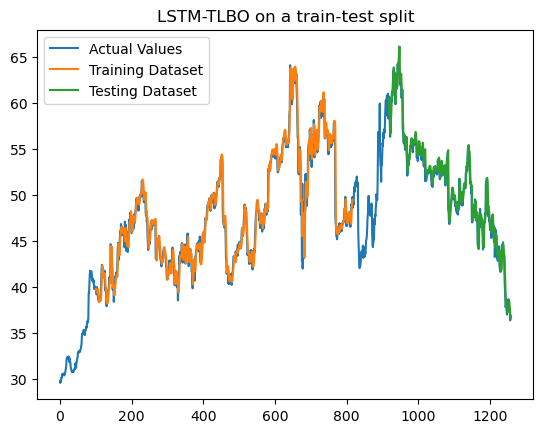

In [34]:
look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

labels = ['Actual Values' , 'Training Dataset', 'Testing Dataset']
plt.title("LSTM-TLBO on a train-test split")
plt.legend(labels)
plt.show()

### Visualization of loss

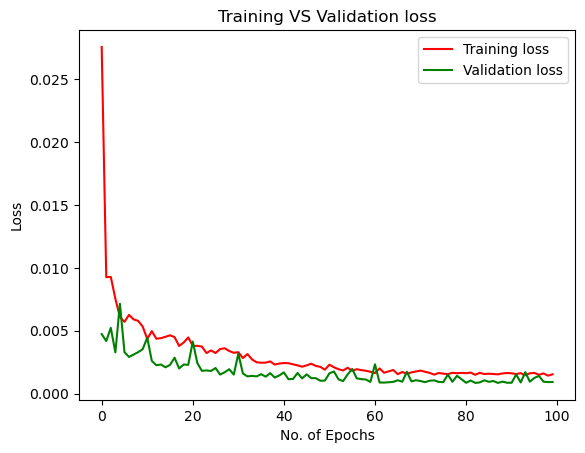

In [35]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Final Verdict

In [36]:
# Our prediction of the stock price from last training timestamp to last tested timestamp
print("The price will move from", (str(val)[1:-1]),"to" , str(val_test)[1:-1])

The price will move from 49.477196 to 36.622974
